One of the central concerns of our work from the beginning has been getting the matter of *words* right. While so-called stopwords, sometimes also imagined as an extended set of function words to include words too common to be of any use in distinguishing one text from another, have proven useful in many applications, we felt it was better to keep all the words in our initial processing of the corpus and only remove words in later experiments as they proved problematic -- read "mostly harmless" -- in a particular context.

## Infrastructure: Loading Libraries and Data

In [2]:
% matplotlib inline 

In [1]:
import re, csv, pandas as pd, numpy as np
from nltk.tokenize import WhitespaceTokenizer

In [3]:
# Load the CSV into a dataframe and then place all the texts into a list:

df = pd.read_csv('tedtalks2018.csv')
print(df.shape)

texts = df.text.tolist()
labels = df.headline.tolist()

(2656, 12)


## Initial Tokenization

Now we need to determine the best way forward for tokenization. In other projects, we have used the NLTK's`WhitespaceTokenizer`, so we will begin there and check the results.

In [5]:
# List of word counts for each talk 
counts = [len(WhitespaceTokenizer().tokenize(text)) for text in texts]
print("Of the {} talks, the shortest is {} words; the longest {}; and the average {}.".format(
    len(counts),min(counts), max(counts), int(np.mean(counts))))

Of the 2656 talks, the shortest is 2 words; the longest 9185; and the average 2045.


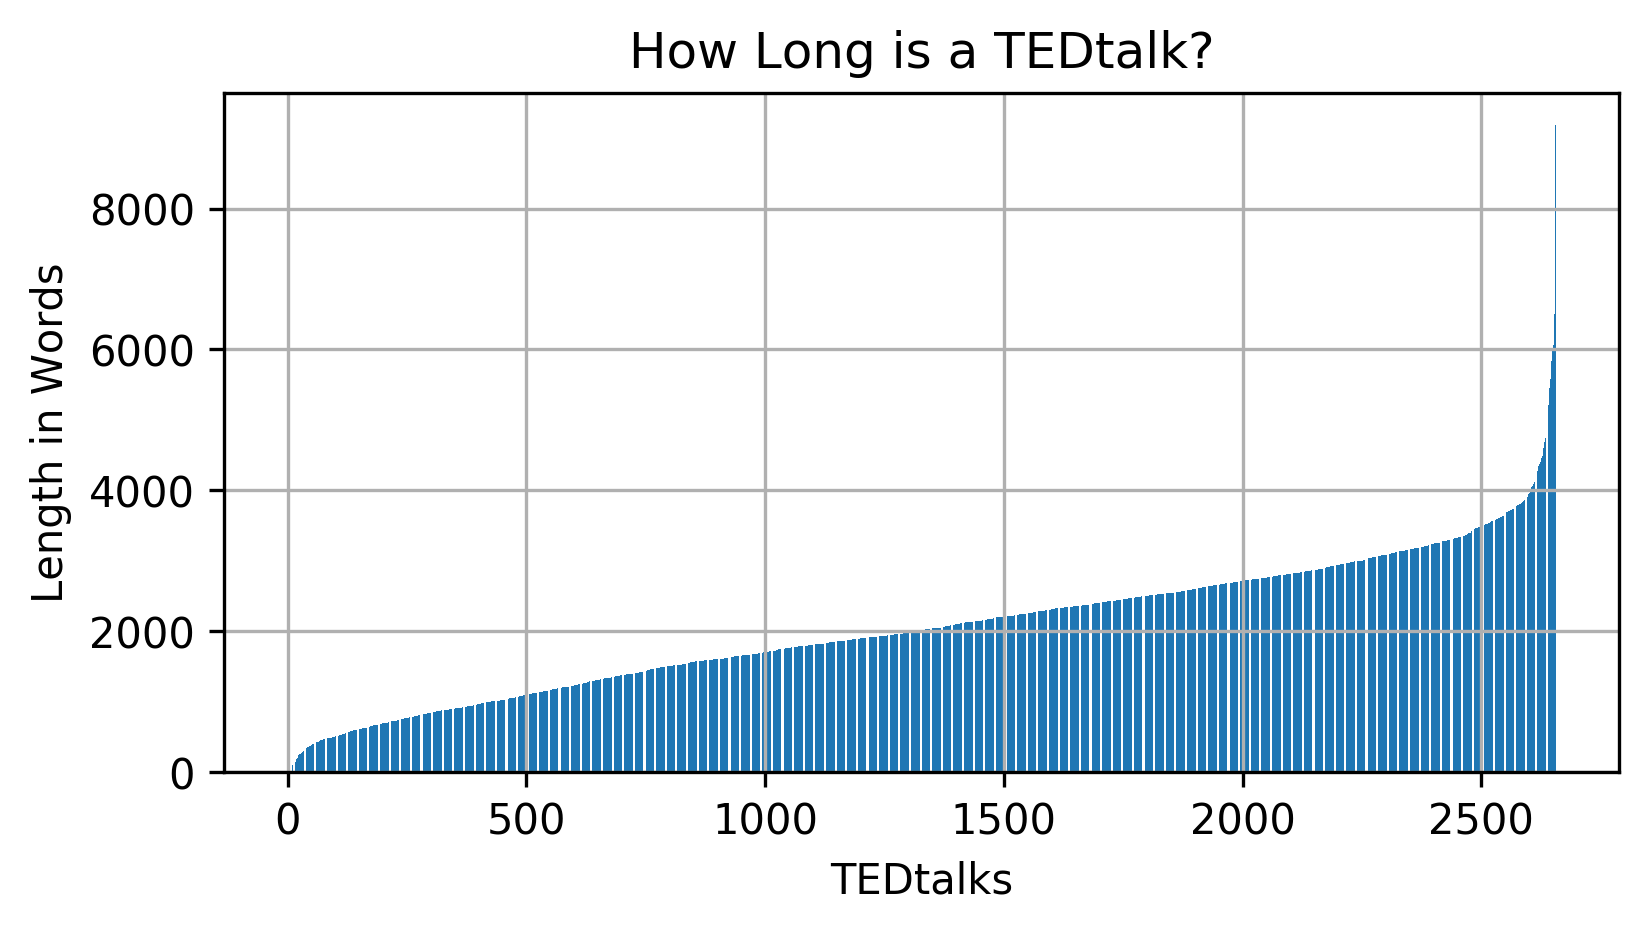

In [6]:
# =-=-=-=-=-=-=-=-=-=-=
# Quick Word Count Visualization
# =-=-=-=-=-=-=-=-=-=-= 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 3), dpi=300, facecolor='w', edgecolor='k')

# Plot of Word Lengths
length_sorted = sorted(counts)
plt.bar(range(len(length_sorted)), length_sorted)
plt.xlabel('TEDtalks')
plt.ylabel('Length in Words')
plt.title('How Long is a TEDtalk?')
plt.grid(True)
plt.show()

## Parentheticals

When are words not words? In the case of TED talks, when they are descriptions of actions or events outside the text of the talk itself. In the quick examination of the word counts above, the shortest text is two words. Neither of those words were, however, spoken by anyone:

In [7]:
for text in texts:
    if len(WhitespaceTokenizer().tokenize(text)) == 2:
        print(text)

  (Music)    (Applause)  


That's two parentheticals describing a musical performance. Let's repeat that code and see how big a text can get before we get spoken words.

In [8]:
# Incrementing 'less than' until I get spoken words.
for text in texts:
    if len(WhitespaceTokenizer().tokenize(text)) < 100:
        print(text)

  (Applause)    (Music)    (Applause)  
  Let's just get started here.    Okay, just a moment.    (Whirring)    All right. (Laughter) Oh, sorry.    (Music) (Beatboxing)    Thank you.    (Applause)  
  (Music)    (Applause)    (Music)    (Music) (Applause)    (Music) (Applause) (Applause)    Herbie Hancock: Thank you. Marcus Miller. (Applause) Harvey Mason. (Applause)    Thank you. Thank you very much. (Applause)  
  (Music)    (Applause)    (Music)    (Applause)  
  (Music)    (Applause)    (Music)    (Applause)    (Music)    (Applause)    (Music)    (Applause)  
  (Mechanical noises)    (Music) (Applause)  
  (Music)    (Applause)  
  (Music)    (Music) (Applause)    (Applause)  
  (Guitar music starts)    (Music ends)    (Applause)    (Distorted guitar music starts)    (Music ends)    (Applause)    (Ambient/guitar music starts)    (Music ends)    (Applause)  
  (Guitar music starts)    (Cheers)    (Cheers)    (Music ends)  


I started with 10 words and incremented by 10 until I got to 100, then to 150 and 200. From 10 words to 100 words, the results do not change that much: these are musical performances. Somewhere between 100 and 200 words, the lyrics of sung performances produce a transcript. We will need to set a threshold for the text we treat, but we will also need to consider the role of parentheticals in our analysis.

Can we see a list of parentheticals as a set?

In [9]:
# First, let's see a list of parentheticals in a talk:
re.findall('\(([^)]+)', texts[0])

['Mock sob',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Applause',
 'Laughter',
 'Mock sob',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Applause',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Laughter',
 'Applause',
 'Applause',
 'Applause',
 'Laughter',
 'Applause']

In [10]:
# Getting a set is not a problem:
set(re.findall('\(([^)]+)', texts[0]))

{'Applause', 'Laughter', 'Mock sob'}

In [11]:
# Now to get a set for all the talks:
parentheticals = []
for text in texts:
    parentheticals.append(re.findall('\(([^)]+)', text))
    
# print(parentheticals) # Reveals that we have a list of lists

In [12]:
# The easiest way to flatten a list of lists is
parens_all = sum(parentheticals, [])
len(parens_all)

19570

Okay, so we have 19,570 parentheticals. At the very least, we can deduct that number from our total word count -- if we can't determine a way to remove them from our texts using some regex-fu. In the mean time, let's take a look at the set of all the parentheticals:

In [13]:
print(parens_all[0:10])

['Mock sob', 'Laughter', 'Laughter', 'Laughter', 'Laughter', 'Applause', 'Laughter', 'Mock sob', 'Laughter', 'Laughter']


In [14]:
paren_set = set(parens_all)
print (len(paren_set), paren_set)

878 {'"What makes a great leader in the 21st century?"', 'Bono: [unclear]', 'Audience: "Theme of Paganini."', 'PM: Rap. Break dancing.', "Albinoni's Adagio", 'Audience reacts', 'Laughted', 'High pitch buzz', 'Music: The Star-Spangled Banner', 'Audience murmurs', "Audience: It's getting too much.", 'Trumpet', 'Braying', '@melodiumbox', 'laughter', 'Shouting', 'Music: "Teardrop" by Massive Attack', 'Music: "Shells" by Mirah', 'Shreiks', 'Audience: Laughter', 'Music with unintelligible lyrics', 'Drum beat', 'Woman screams', 'Coughs', 'Audience: Seven of diamonds.', 'MS: Thanks so much.', 'AV: Thank you.', 'along with a lot of other stuff', 'RD: Yeah.', 'Circus music', '2 ^ 67', 'Pitch getting higher and lower', 'Final chord', 'Plays notes', 'Audience roars', 'Audience: Diamonds.', 'Recording of crowd cheering', 'k', 'Pre-recorded applause', 'Drum sound', 'Music: "We Can\'t Stop" by Miley Cyrus', 'Birds chirp', 'Audience: Ten of diamonds.', '"What\'s a Jurassic Park?"', 'Singing', 'Inaudib

Oi, we've got stuff in parentheses that shouldn't be there: we'll have to hand inspect the texts above and see if we need to make any corrections. 

How big is our total word count that these ~20,000 words might affect us? A quick summing of the `counts` from above -- `sum(counts)` -- reveals our total word count is: 5,432,831. Dividing all our parentheticals by our total word count gives us an impact of 0.3%:

In [15]:
len(parens_all)/sum(counts)

0.00360217352610453

It's not a large enough factor to worry about now, but, at some point, we'll want to re-visit what's inside parentheses and determine what to do about it.

## Refined Tokenization

Okay, now we need to look at the tokens involved, and we might as well get a frequency for each token while we are at it. 

Previously, we have used the following code:


```python
# =-=-=-=-=-=-=-=-=-=-=
# Corpus Word Frequencies: RAW
# =-=-=-=-=-=-=-=-=-=-= 

# Mash all the talks together & then tokenize
alltalks = " ".join(texts).lower()
tokens = WhitespaceTokenizer().tokenize(alltalks)

# Build a dictionary of words and their frequency in the corpus
word_freq = {}
for token in tokens:
    try:
        word_freq[token] += 1
    except: 
        word_freq[token] = 1

# Convert dictionary into a list of tuples
freq_list = [(val, key) for key, val in word_freq.items()]

# Sort with most frequent words at top
freq_list.sort(reverse=True)

print(len(tokens), len(freq_list))

# Write to file
with open('word_freq.csv', 'w') as f:
        wtr = csv.writer(f)
        wtr.writerows(sorted(freq_list, reverse=True))
        f.close()
```

An examination of the CSV reveals that most rows are numbers followed by words, and that we happily have contractions included:

```
252601,the
182275,and
155808,to
140032,of

1637,i'll
1956,i'd
3891,i've
6928,there's
9725,don't
12199,that's
```

But there are more than a few exceptions where the words are enclosed in quotations, or are followed by punctuation, or are numbers. (The numbers may not pose a problem, especially if we can KWiC them to see if we get regular counts of certain kinds of things.)

```
524,"back,"
553,"first,"
593,"""what"

557,too.
663,that?
703,problem.

621,40
900,50
```

So what we want to do is get rid of all forms of punctuation *except* apostrophes, and we want to do that *after* NLTK's `WhitespaceTokenizer` has done its job. (This strikes me as redundant, and that we would probably be better off building a custom regex tokenizer, but we'll just modify our "off the shelf" solution for now.) 

The regex I am going to try is: `re.sub(ur"[^\w\d']+", '', item)`, which, as I understand it, means "don't replace words, numbers, or apostrophes with nothing."

So, first we'll create the jumbo string and then create a giant list of tokens.

In [16]:
alltalks = " ".join(texts).lower()
tokens = WhitespaceTokenizer().tokenize(alltalks)

In [17]:
print(tokens[0:20])

['thank', 'you', 'so', 'much,', 'chris.', 'and', "it's", 'truly', 'a', 'great', 'honor', 'to', 'have', 'the', 'opportunity', 'to', 'come', 'to', 'this', 'stage']


In [18]:
nopunct = [re.sub("[^\w\d']+", '', token) for token in tokens]

For whatever reason, Python wasn't accepting the *`ur`* modifier to the character class description. When I removed it, no errors were returned. Now to run the usual code and see what kind of list we get:

In [19]:
# Build a dictionary of words and their frequency in the corpus
word_freq = {}
for item in nopunct:
    try:
        word_freq[item] += 1
    except: 
        word_freq[item] = 1

# Convert dictionary into a list of tuples
freq_list = [(val, key) for key, val in word_freq.items()]

# Sort with most frequent words at top
freq_list.sort(reverse=True)

print(len(tokens), len(freq_list))

5432831 73302


Okay, we have the same number of tokens to start, which seems right, but we have half the number of word types. Encouraging.

In [ ]:
# Write to file
with open('word_freq_np.csv', 'w') as f:
        wtr = csv.writer(f)
        wtr.writerows(sorted(freq_list, reverse=True))
        f.close()

In [43]:
def CorpusWordFrequency (dictionary, number):
    wf = []
    for word, count in dictionary.items():
        if count == number:
            wf.append(word)
    print("The number of words that occur "+str(number)+
          " times in this corpus is "+str(len(wf))+".")

In [39]:
CorpusWordFrequency(word_freq, 1)

The number of words that occur 1 times in this corpus is 29124.


In [44]:
CorpusWordFrequency(word_freq, 2)

The number of words that occur 2 times in this corpus is 9792.


In [46]:
for count in range(1,10):
    CorpusWordFrequency(word_freq, count)

The number of words that occur 1 times in this corpus is 29124.
The number of words that occur 2 times in this corpus is 9792.
The number of words that occur 3 times in this corpus is 5358.
The number of words that occur 4 times in this corpus is 3772.
The number of words that occur 5 times in this corpus is 2592.
The number of words that occur 6 times in this corpus is 1999.
The number of words that occur 7 times in this corpus is 1549.
The number of words that occur 8 times in this corpus is 1285.
The number of words that occur 9 times in this corpus is 1051.


Having done this, I realize that SciKit Learn's word frequency array could be used instead of this.